In [39]:
#import dependencies
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import datetime
from sklearn.preprocessing import StandardScaler

In [40]:
#model choices
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [41]:
#evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [42]:
#set yfinance to fetch required data
yf.pdr_override

start='2010-01-01'
end=datetime.datetime.now().strftime("%Y-%m-%d")
company='FB'
train_cutoff="2018-12-31"

In [43]:
#function to get data
def get_data(company, start, end):
  print('Getting the data...')

  df = pdr.get_data_yahoo("FB", start, end).reset_index()
  
#   df.to_csv('FB.csv', index=False)
  df_aang=pdr.get_data_yahoo(['AAPL','AMZN','NFLX','GOOG'], start).reset_index()

  #initializing columns
  for i in df_aang.Open.columns:
    df_aang['PCT_change',i]=0.0

  for i in df_aang.Open.columns:
    df_aang['HL_PCT',i]=0.0

  #adding data
  for i in df_aang.Open.columns:
    df_aang['PCT_change',i]=(df_aang['Close'][i]-df_aang['Open'][i])/df_aang['Open'][i]*100.0
    df_aang['HL_PCT',i]=(df_aang['High'][i]-df_aang['Low'][i])/df_aang['Close'][i]*100.0
  
  #merge the newly created features
  df=df.merge(df_aang[['Date','PCT_change','HL_PCT']], how='left', on='Date')

  df['HL_PCT_FB']=(df['High']-df['Low'])/df['Close']*100.0
  df['PCT_change_FB']=(df['Close']-df['Open'])/df['Open']*100.0

  return df

In [44]:
#preprocess data
def preprocessing(df):
  scaler=StandardScaler()
  xtrain=df[df['Date']<=train_cutoff].drop(['Close','Adj Close','Date'],axis=1)
  xtest=df[df['Date']>train_cutoff].drop(['Close','Adj Close','Date'],axis=1)

  xtrain=scaler.fit_transform(xtrain)
  xtest=scaler.fit_transform(xtest)

  ytrain=df[df['Date']<=train_cutoff]['Close']
  ytest=df[df['Date']>train_cutoff]['Close']

  return xtrain,xtest,ytrain,ytest

In [45]:
#find best model
def best_model(df):
  print('\nCalculating...')

  model_name=['Linear regression', 'Random forest regressor', 'Support vector regressor', 'K-Neighbors regressor', 'Ridge']
  
  xtrain,xtest,ytrain,ytest=preprocessing(df)
  
  best_pred=[]
  best_mse=[]
  best_r2=[]

  #linear regression
  linreg=LinearRegression().fit(xtrain,ytrain)
  lin_pred=linreg.predict(xtest)
  best_pred.append(lin_pred)
  best_mse.append(mse(lin_pred,ytest))
  best_r2.append(r2_score(ytest,lin_pred))

  #random forest
  rfr=RandomForestRegressor(n_estimators=100).fit(xtrain,ytrain)
  rfr_pred=rfr.predict(xtest)
  best_pred.append(rfr_pred)
  best_mse.append(mse(rfr_pred,ytest))
  best_r2.append(r2_score(ytest,rfr_pred))

  #SVR
  svr=SVR().fit(xtrain,ytrain)
  svr_pred=svr.predict(xtest)
  best_pred.append(svr_pred)
  best_mse.append(mse(svr_pred,ytest))
  best_r2.append(r2_score(ytest,svr_pred))

  #KNN
  knn=KNeighborsRegressor().fit(xtrain,ytrain)
  knn_pred=knn.predict(xtest)
  best_pred.append(knn_pred)
  best_mse.append(mse(knn_pred,ytest))
  best_r2.append(r2_score(ytest,knn_pred))
    
  #Ridge
  rdg=Ridge().fit(xtrain,ytrain)
  rdg_pred=rdg.predict(xtest)
  best_pred.append(rdg_pred)
  best_mse.append(mse(rdg_pred,ytest))
  best_r2.append(r2_score(ytest,rdg_pred))
    
  print("*****************************")  
  print("model names:", model_name)
  print("*****************************")
  print("best_mse", best_mse)
  print("*****************************")
  print("best_r2", best_r2)
  print("*****************************")

  idx=best_mse.index(min(best_mse))

  return (model_name[idx],best_pred[idx],best_mse[idx],best_r2[idx])

In [46]:
#main function
def run():
  df=get_data(company, start, end)
  xtrain,xtest,ytrain,ytest=preprocessing(df)
  model_name, best_pred, best_mse, best_r2=best_model(df)
  
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18, 4))
  fig.suptitle(('The best model was %s, with mse of %6.2f and r2 score of %5.2f' % (model_name, best_mse, best_r2)), fontsize=16)

  ax1.set_xlabel('Predicted values', fontsize=15)
  ax1.set_ylabel('Observed values', fontsize=15)

  ax1.scatter(best_pred,ytest)

  ax2.set_xlabel('Date', fontsize=15)
  ax2.set_ylabel('Share Price', fontsize=15)
  ax2.plot(df[df['Date']>train_cutoff]['Date'],ytest,color='green')
  ax2.plot(df[df['Date']>train_cutoff]['Date'],best_pred)
  ax2.legend(['Actual','Predicted'])
  plt.show()

  return model_name, best_pred, best_mse, best_r2

Getting the data...


/Users/ganagni/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)



Calculating...
*****************************
model names: ['Linear regression', 'Random forest regressor', 'Support vector regressor', 'K-Neighbors regressor', 'Ridge']
*****************************
best_mse [7400.896561898036, 6615.6529198375265, 6372.768810187197, 6229.358342428354, 7397.111587494364]
*****************************
best_r2 [-26.461330229065567, -23.547651489665977, -22.646420039298334, -22.114289616924165, -26.447285926305963]
*****************************


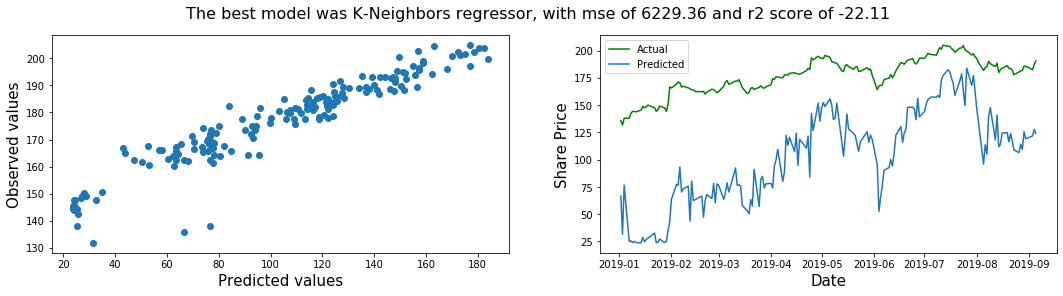

In [47]:
#run and get results
model_name, best_pred, best_mse, best_r2 = run()